Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64 

Class distribution (%):
 Class
0.0    99.771965
1.0     0.228035
Name: proportion, dtype: float64 



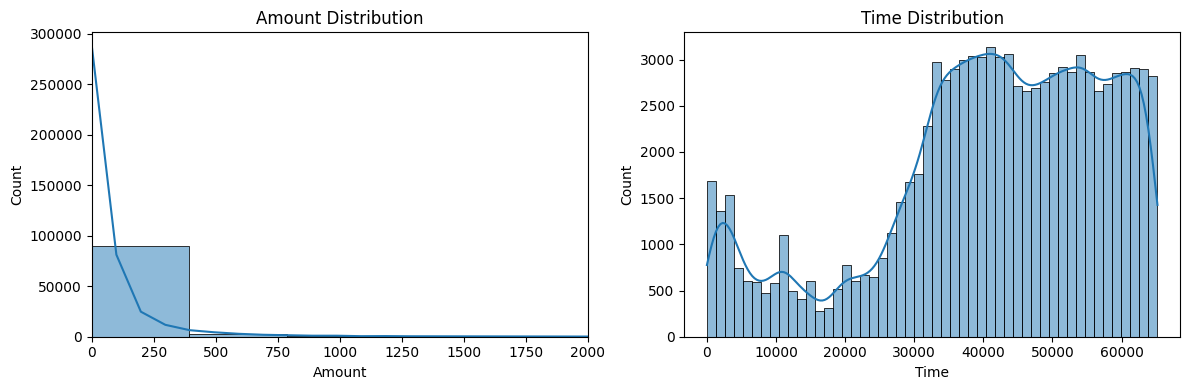

=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9998    0.9807    0.9902     28484
           1     0.0970    0.9077    0.1753        65

    accuracy                         0.9806     28549
   macro avg     0.5484    0.9442    0.5827     28549
weighted avg     0.9977    0.9806    0.9883     28549

ROC-AUC: 0.9831794907802491 

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     28484
           1     0.9623    0.7846    0.8644        65

    accuracy                         0.9994     28549
   macro avg     0.9809    0.8923    0.9321     28549
weighted avg     0.9994    0.9994    0.9994     28549

ROC-AUC: 0.959342356842708 

=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     28484
           1     0.9000    0.8308    0.8640        65

    accuracy                         0.9994     28549
   

In [ ]:
# Complete Credit Card Fraud Detection Pipeline
# ------------------------------------------------
# 1) Install required packages (once):
#    pip install pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

# ==== EDIT THIS TO YOUR FILE NAME ====
FILENAME = '3cf2c830-c7ce-4dd1-8e33-6329e9dd27b5.csv'
# ======================================

# 1. Load data
df = pd.read_csv('creditcard.csv')

# 2. Clean data: drop any rows where Class is missing
df = df.dropna(subset=['Class'])

# 3. Exploratory Data Analysis (brief prints)
print("Missing values per column:\n", df.isnull().sum(), "\n")
print("Class distribution (%):\n", df['Class'].value_counts(normalize=True)*100, "\n")

# Optional: visualize Amount and Time
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Amount'], bins=50, kde=True); plt.title('Amount Distribution'); plt.xlim(0,2000)
plt.subplot(1,2,2)
sns.histplot(df['Time'], bins=50, kde=True); plt.title('Time Distribution')
plt.tight_layout(); plt.show()

# 4. Feature Engineering
# 4.1 Log-transform the Amount to reduce skew
df['Log_Amount'] = np.log(df['Amount'] + 1)
# 4.2 Scale Time and Log_Amount to mean=0, std=1
scaler = StandardScaler()
df[['Time_Scaled','Log_Amount_Scaled']] = scaler.fit_transform(df[['Time','Log_Amount']])
# 4.3 Drop raw features
df = df.drop(['Amount','Log_Amount'], axis=1)

# 5. Prepare features X and target y
X = df.drop('Class', axis=1)
y = df['Class'].astype(int)

# 6. Train/Test split (70/30 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 7. Baseline: Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]), "\n")

# 8. Stronger: Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]), "\n")

# 9. Advanced: XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]), "\n")

# 10. Hyperparameter Tuning for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=8,
    scoring='f1',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print("Best Random Forest Params:", rs.best_params_, "\n")

# 11. Evaluate Tuned Random Forest
y_pred_best = best_rf.predict(X_test)
print("=== Tuned Random Forest ===")
print(classification_report(y_test, y_pred_best, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), "\n")

# 12. Threshold Optimization on Tuned RF
probs = best_rf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_ix = np.nanargmax(f1_scores)
best_threshold = thresholds[best_ix]
print(f"Optimal threshold: {best_threshold:.2f}\n")

y_pred_opt = (probs >= best_threshold).astype(int)
print("=== Tuned RF @ Optimal Threshold ===")
print(classification_report(y_test, y_pred_opt, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, probs), "\n")

# 13. ROC Curve Comparison
plt.figure(figsize=(8,6))
for name, model in [('LR', lr), ('RF', rf), ('XGB', xgb), ('TunedRF', best_rf)]:
    p = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
